# Cropland Mapping with Random Forests and Neural Networks

# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import warnings


Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-8e2f8f279f9c>", line 11, in <module>
    from keras.models import Sequential
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\keras\__init__.py", line 3, in <module>
    from . import utils
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\keras\utils\__init__.py", line 6, in <module>
    from . import conv_utils
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\keras\utils\conv_utils.py", line 9, in <module>
    from .. import backend as K
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\keras\backend\__init__.py", line 1, in <module>
    from .load_backend import epsilon
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\keras\backend\load_backend.py", line 90, in <module>
    from .tensorflow_backend import *
  File "C:\Users\Abhishek\Anaco

ModuleNotFoundError: No module named 'tensorflow.python.platform'

In [2]:
warnings.filterwarnings('ignore')
sns.set()
start_time = datetime.now()

### Customized functions

In [3]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='orangered')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(40, 20))
        f_map = sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                            center=0, cmap="RdYlBu")
    plt.show()

### Importing the dataset

The dataset containing 325,834 observations is imported and shuffled.

In [4]:
# Importing the dataset
dataset = pd.read_csv('../input/cropland-mapping/WinnipegDataset.txt')
dataset = dataset.sample(frac=1)

## Exploratory data analysis and preprocessing

A glimpse at the dataset structure confirms observation shuffling.

In [5]:
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
21597,1,-11.760,-19.615,-8.8321,-12.217,-10.186,-12.786,-2.92800,-7.8547,-10.7830,...,0.50617,-0.18898,0.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
226300,5,-15.544,-24.281,-16.0640,-19.786,-14.564,-19.618,0.52015,-8.7377,-8.2176,...,0.48148,0.00000,1.7778,0.17284,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
99236,3,-11.230,-18.634,-13.6870,-14.516,-11.739,-15.307,2.45720,-7.4046,-4.9474,...,1.00000,1.00000,3.0000,0.00000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
248300,6,-17.454,-28.726,-20.0580,-23.626,-17.003,-23.096,2.60370,-11.2710,-8.6675,...,0.40741,-0.28571,1.7778,0.17284,0.66667,0.66667,0.66667,1.06090,0.35802,-0.47809
61544,3,-11.304,-19.543,-14.0880,-15.490,-11.646,-15.610,2.78370,-8.2384,-5.4547,...,0.28395,0.70000,4.5556,0.24691,0.88889,0.22222,0.22222,1.06090,0.35802,0.63246


In addition, the analysis of unique labels shows a somehow balanced distribution (class share percentages mapped and charted below), with the exception of '<b>broadleaf</b>' and '<b>pea</b>'. Watchful eyes will be on these two classes along the exercise.

In [6]:
class_share = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,7):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class 1: 12.02 %
Class 2: 1.10 %
Class 3: 23.22 %
Class 4: 22.73 %
Class 5: 14.46 %
Class 6: 26.11 %
Class 7: 0.35 %


Text(0, 0.5, 'Share (%)')

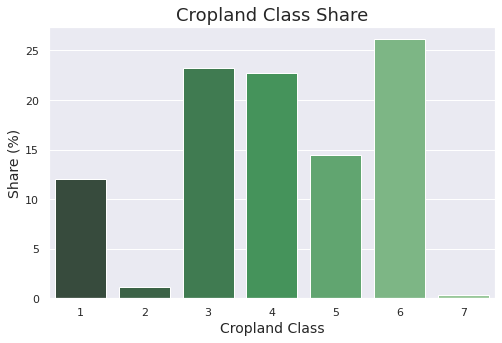

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(ax=ax, x = class_share.index, y = class_share, palette='Greens_d')
plt.title('Cropland Class Share', fontsize=18)
plt.xlabel('Cropland Class', fontsize=14)
plt.ylabel('Share (%)', fontsize=14)

###  Correlation

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired colinearity.
The code below assists in identifying and sorting high feature intercorrelation cases based on the corresponding correlation coefficients (in descending order). A threshold of 0.95 has been arbitrarily defined for filtering highly intercorrelated features.

In [8]:
highly_correlated_feature_pairs = []
highly_correlated_features_to_drop = []

correlation_matrix = dataset.corr().abs()
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])
            
print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')

Number of highly intercorrelated feature pairs: 117


In [9]:
highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correl']
highly_correlated_feature_pairs.head(10)

,feature_1,feature_2,correl
4,2,39,1.000000
38,51,88,1.000000
109,151,153,1.000000
45,54,86,1.000000
8,5,37,1.000000
102,142,147,1.000000
113,156,157,0.998716
13,7,15,0.995524
10,6,38,0.995455
60,62,79,0.995254


Features to be dropped are pinned on a correlation map and removed from the dataset.

In [10]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[highly_correlated_features_to_drop], axis=1)

In [11]:
nr_features = dataset.shape[1] - 1
print(f'Optimized number of features: {nr_features}')

Optimized number of features: 102


After dropping, the number of features was substantially reduced from 174 down to 102 (a 41.4 % decrease). Such dimensionality optimization not only assists in mitigating colinearity but also allows for the creation of streamlined machines and faster learning with lower processing and memory requirements.
A final correlation map including the dependent variable ('label') and the remaining feature set is charted below.

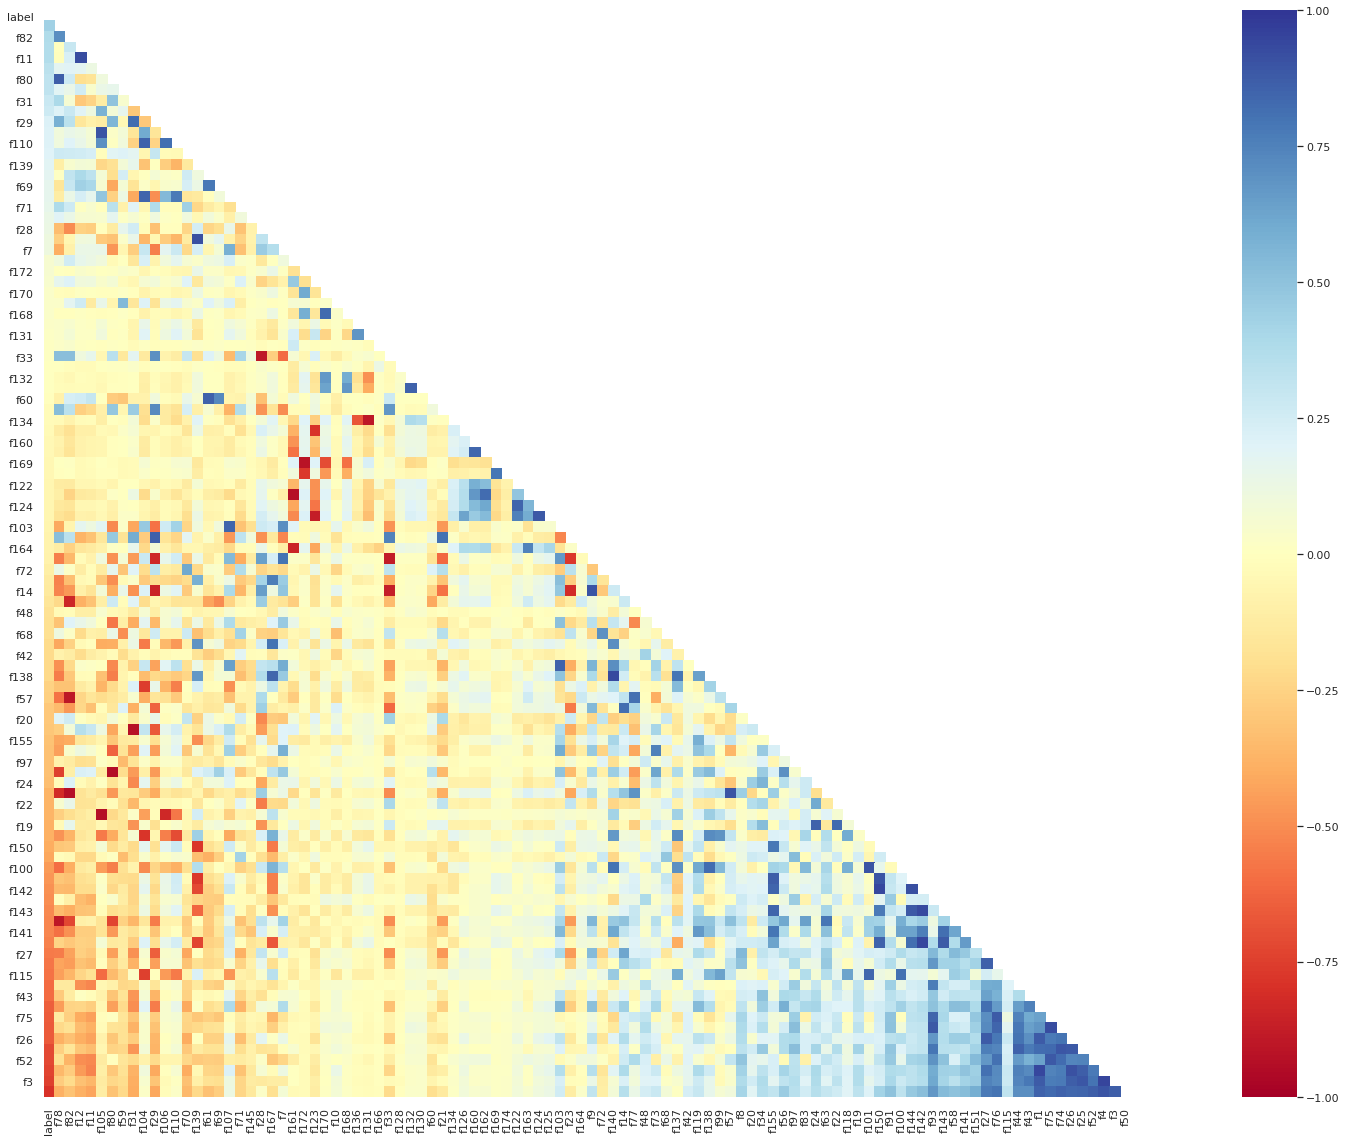

In [12]:
correlation_map(dataset, 'label', nr_features)

### Feature assessment

Invoking the 'assessment' custom function allows for plotting feature distribution patterns and their relationship with the 'label' dependent variable. This is done for the 10 features most correlated with the dependent variable 'label', just to provide a first glimpse of data behavior:

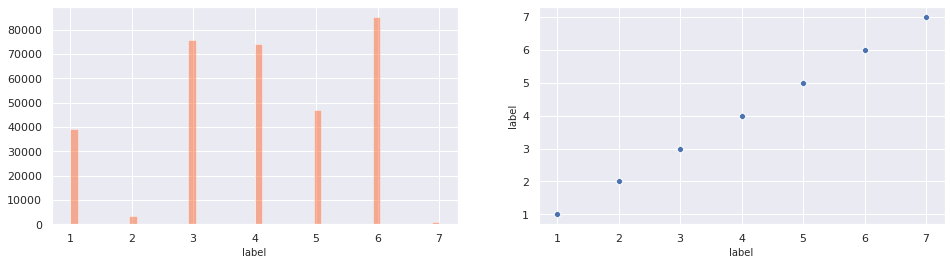

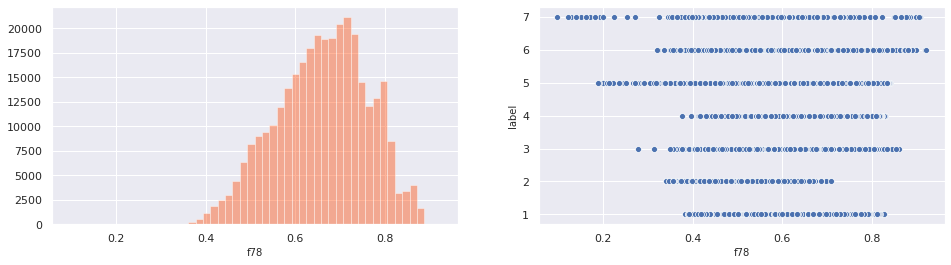

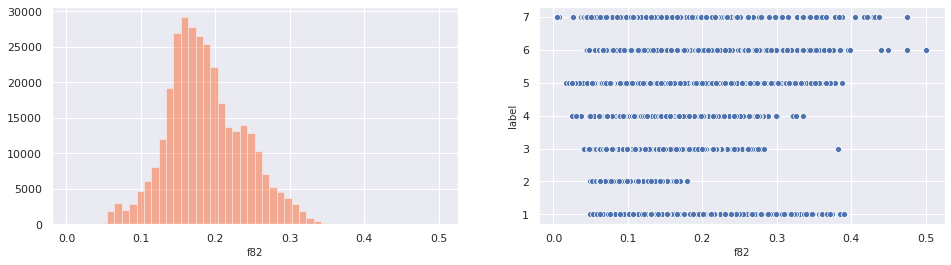

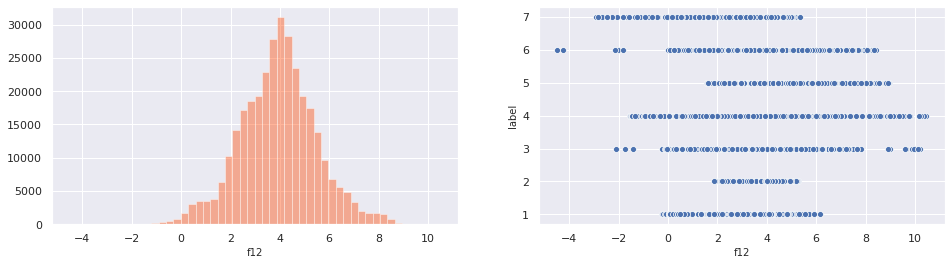

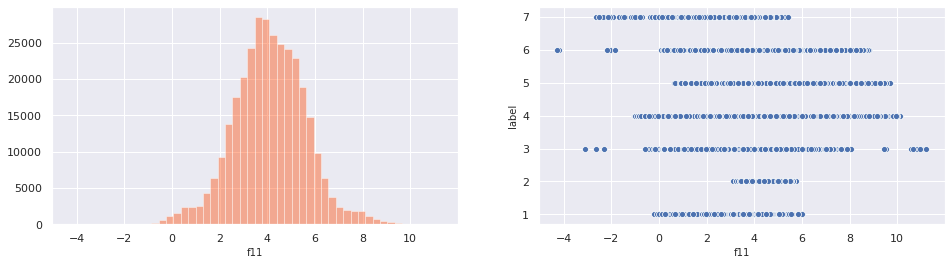

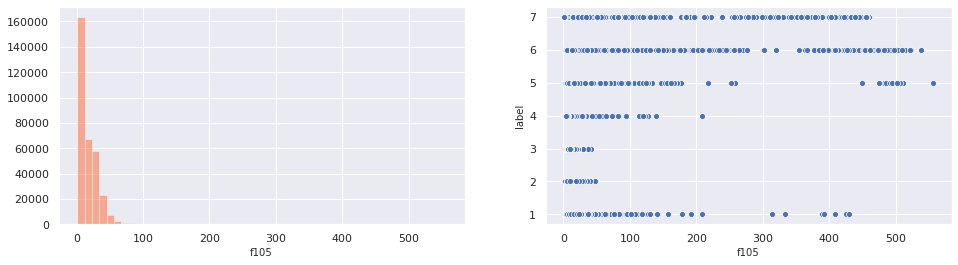

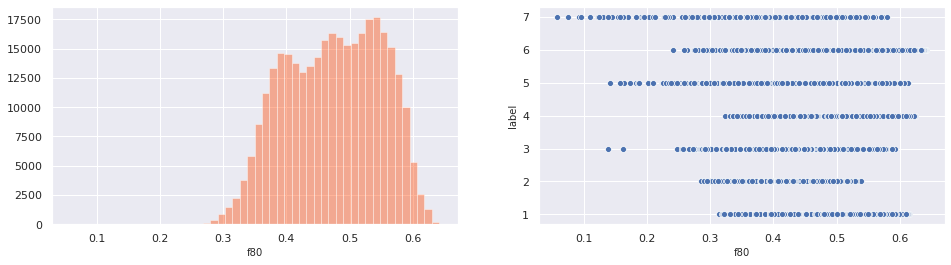

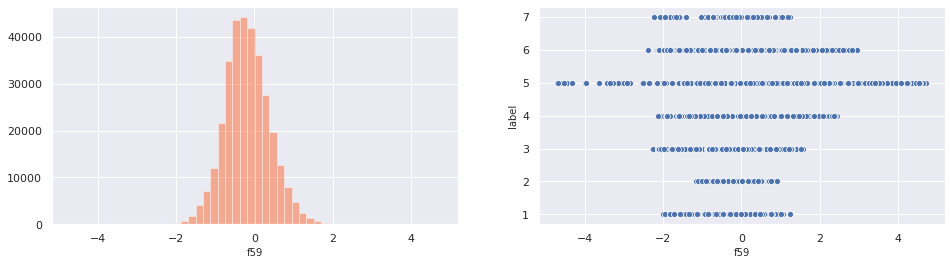

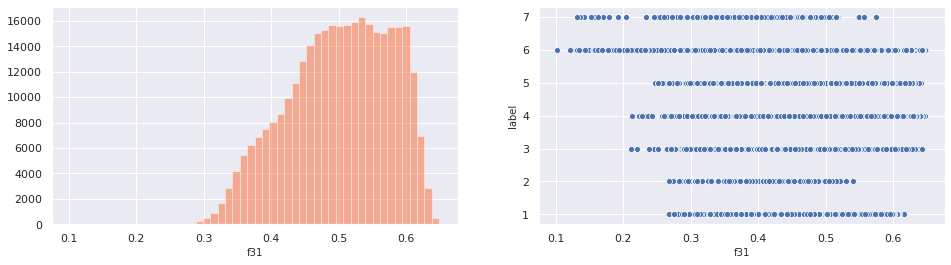

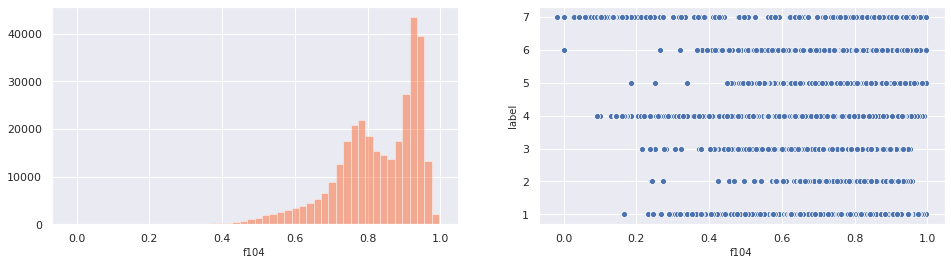

In [13]:
most_correlated_features = dataset.corr().nlargest(10,'label')['label'].index

for column in most_correlated_features:
    assessment(dataset, 'label', column, -1)

The analysis shows that some variables are indeed skewed. However, no transformation will be performed a priori. This decision may be revisited later in light of the overall performance of trained classifiers.

### Segregating train and test sets

As both classical (random forests) and deep (neural networks) machine learning solutions will be compared, two different sets of tensors will be developed, allowing for their use in each learning exercise.
After the elimination of highly intercorrelated features, our dataset now contains 325,834 observations with:
- One column for labels (integers ranging from 1 to 7);
- 102 columns for features.

The <b>features tensor</b> will be unique, serving both exercises.

Two <b>label tensors</b> will be constructed:
    - For the <b>random forest</b> classification, original labels (integers ranging from 1 to 7) will be preserved and accommodated into one unidimensional array;
    - For the <b>neural network</b> classification, the label column will be one-hot enconded with the help of Pandas' get_dummies method. Therefore, labels will now consist of arrays with seven binary elements, each of them referring to a specific crop class, allowing for the final class identification based on the array element with the highest predicted value.
    
    
The unique features tensor and the two label tensors are subsequently split into training and testing sets. The training set will host 80% of observations, while the testing set will accommodate the remaining 20%. Such proportions were arbitrarily chosen by the author.

In [14]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0:1]

In [15]:
train_size = round(0.8 * len(X))

In [16]:
X_train = X.iloc[:train_size, :].values
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:, :].values
y_test = y.iloc[train_size:]

In [17]:
class_count = pd.Series(y_test.label.value_counts()).sort_index()
print('Class count - Test labels\n')
for i in range(0,7):
    print(f'Class {class_count.index[i]}: {class_count.iloc[i]}')

Class count - Test labels

Class 1: 7742
Class 2: 728
Class 3: 15011
Class 4: 14825
Class 5: 9591
Class 6: 17034
Class 7: 236


Finally, label tensors (numpy arrays) are created for each separate exercise (random forest and neural network).

In [18]:
y_train_rf = y_train.label.values
y_test_rf = y_test.label.values

y_train_ann = pd.get_dummies(y_train.label).values
y_test_ann = pd.get_dummies(y_test.label).values

### Feature scaling

Scaling is performed on the training feature set only and applied to both training and testing feature sets (with the 'fit_transform' and 'transform' methods, respectively).

In [19]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Machine Learning

### Part I - Random Forest

####  Model fitting

The classifier will be instantiated with n_estimators = 100 (i.e. the forest will comprise 100 decision trees) and n_jobs = 4 (allowing for the use of 4 processing cores).
The author selected a number of trees relatively close to the final number of features (102) for a first shot. However, a more robust optimization of relevant hyperparameters is recommended, e.g. through the use of <b>validation curves</b>. Readers are welcome to experiment.

In [20]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=4)

random_forest_classifier.fit(X_train, y_train_rf)

RandomForestClassifier(n_jobs=4)

####  Predictions

After fitting the model to the training set, predictions are generated for the testing set. As a reminder, predictions for each observation will be scalars ranging from 1 to 7, referring to one particular crop class:

In [21]:
y_pred_rf = random_forest_classifier.predict(X_test)

For information only (a first sanity check), the first prediction in the 'y_pred_rf' array matches the actual class for the corresponding test set observation hosted in the 'y_test_rf' array. So far, so good...

In [22]:
print(f'Predicted class: {y_pred_rf[0]}')
print(f'Actual class: {y_test_rf[0]}')

Predicted class: 6
Actual class: 6


<p style="text-align: justify"></p>

### Deep Learning (Artificial Neural Network)

The artificial neural network (ANN) architecture comprises a sequential structure with:
    - one input layer (102 input nodes);
    - three hidden layers (204, 204 and 102 nodes, respectively);
    - one seven-node output layer.

As features are standardized real numbers, '<b>relu</b>' is elected as the activation function of choice for hidden layers. In addition, as this is a multiclass classification exercise, where the output is intended to be binary ('1' for the identified class, '0' for all other classes), the choice of '<b>softmax</b>' as the activation function for the output layer seems adequate.
'<b>Adam</b>' has been elected as the optimizer, and its constituent parameters expanded to give some flexibility to play, in particular, with the learning rate. As this is a multiclass classification exercise, '<b>categorical_crossentropy</b>' is selected as the loss function. The fitting performance will be assessed using '<b>accuracy</b>' as the metric of choice.

In [23]:
# ANN
ann_classifier = Sequential()

# Input layer and first dense layer
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu', input_dim = 102))
ann_classifier.add(Dropout(0.1))

# Second dense layer
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Third dense layer
ann_classifier.add(Dense(units = 102, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Output layer
ann_classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

# Model compilation

optim = Adam(learning_rate=0.0005)

ann_classifier.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### Model fitting

As the number of observations is huge, no cross-validation mechanism will be implemented a priori, another decision subject to later revision, if necessary.

In [24]:
ann_train_history = ann_classifier.fit(X_train, y_train_ann, batch_size = 64, epochs = 100, verbose=0)

Training accuracy and loss per training epoch are charted below.
As we are dealing with hundreds of thousands of observations, it is not unusual to see a neural network model converging fast. In this case, batches contain 64 observations. In every epoch the model will be exposed to more than 5,000 different batches. Few epochs may suffice to lead to high accuracy, low loss levels already in the beggining of the training session.

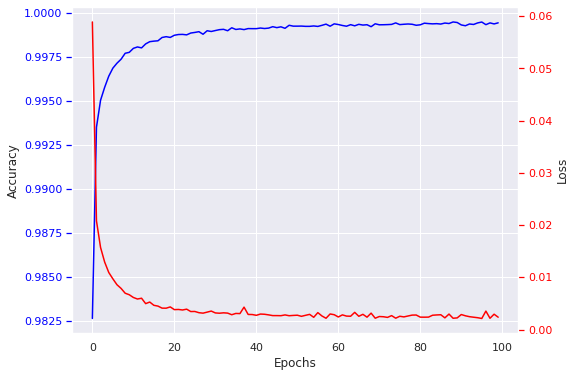

In [25]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.set_style("darkgrid")
ax2 = ax1.twinx()
ax1.plot(ann_train_history.history['accuracy'], color='blue')
ax2.plot(ann_train_history.history['loss'], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', colors='blue')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)
plt.show()

#### Predictions

After fitting the model to the training set, predictions are generated for the testing set. As a reminder, each prediction will correspond to an array with seven elements, each of them referring to one particular crop class. The final array is '<b>binarized</b>': the array element with the highest value will be converted to '1' while all other array elements will be converted to '0'.

In [26]:
y_pred_ann = ann_classifier.predict(X_test)
for i in range(len(y_pred_ann)):
    for j in range(7):
        if y_pred_ann[i][j] == y_pred_ann[i].max():
            y_pred_ann[i][j] = 1
        else:
            y_pred_ann[i][j] = 0
y_pred_ann = y_pred_ann.astype(int)

A new sanity check reveals that the first prediction in the 'y_pred_ann' tensor matches the array generated for the first test set label - the class has been correctly predicted for this particular observation with our neural network.

In [27]:
print(f'Predicted: {y_pred_ann[0]}')
print(f'Actual: {y_test_ann[0]}')

Predicted: [0 0 0 0 0 1 0]
Actual: [0 0 0 0 0 1 0]


## Classification performance

### Random Forest

In [28]:
rf_cm = np.zeros((7,7))

In [29]:
rf_pred_correct = 0
rf_pred_incorrect = 0
for i in range(len(y_test)):
    rf_index_test = y_test_rf[i] - 1
    rf_index_pred = y_pred_rf[i] - 1
    rf_cm[rf_index_test][rf_index_pred] += 1
    if rf_index_test == rf_index_pred:
        rf_pred_correct += 1
    else:
        rf_pred_incorrect += 1

In [30]:
rf_cmatrix = pd.DataFrame(rf_cm.astype(int),
                          index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                          columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
rf_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7714,0,6,14,0,3,5
Pea,1,726,0,1,0,0,0
Canola,1,2,14991,9,3,5,0
Soy,5,0,9,14764,22,25,0
Oat,3,0,5,24,9502,54,3
Wheat,6,0,4,21,22,16978,3
Broadleaf,4,0,1,0,0,4,227


In [31]:
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
rf_precision, rf_recall, rf_f_score, rf_support = precision_recall_fscore_support(y_test_rf, y_pred_rf, average='macro')
print(f'Accuracy: {rf_accuracy * 100:.2f} %')
print(f'Precision: {rf_precision * 100:.2f} %')
print(f'Recall: {rf_recall * 100:.2f} %')
print(f'F-Score: {rf_f_score * 100:.2f} %')

Accuracy: 99.59 %
Precision: 99.03 %
Recall: 99.11 %
F-Score: 99.07 %


In [32]:
print('Accuracy per class\n')
for i in range(len(rf_cmatrix)):
    class_accuracy = rf_cmatrix.iloc[i,i] / rf_cmatrix.sum(axis=0)[i]
    print(f'{rf_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.74 %
Pea: 99.73 %
Canola: 99.83 %
Soy: 99.53 %
Oat: 99.51 %
Wheat: 99.47 %
Broadleaf: 95.38 %


###  Deep Learning (Artificial Neural Network)

In [33]:
ann_cm = np.zeros((7,7))

In [34]:
ann_pred_correct = 0
ann_pred_incorrect = 0
for i in range(len(y_test_ann)):
    if y_pred_ann[i].sum() > 0:
        ann_index_test = np.where(y_test_ann[i] == 1)[0][0]
        ann_index_pred = np.where(y_pred_ann[i] == 1)[0][0]
        ann_cm[ann_index_test][ann_index_pred] += 1
        if ann_index_test == ann_index_pred:
            ann_pred_correct += 1
        else:
            ann_pred_incorrect += 1


In [35]:
ann_cmatrix = pd.DataFrame(ann_cm.astype(int),
                           index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                           columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
ann_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7735,0,2,3,0,1,1
Pea,0,728,0,0,0,0,0
Canola,1,0,14992,7,6,5,0
Soy,2,0,3,14806,4,10,0
Oat,2,0,2,10,9540,37,0
Wheat,1,0,3,4,5,17021,0
Broadleaf,7,0,1,0,4,6,218


In [36]:
ann_accuracy = accuracy_score(y_test_ann, y_pred_ann)
ann_precision, ann_recall, ann_f_score, ann_support = precision_recall_fscore_support(y_test_ann, y_pred_ann, average='macro')
print(f'Accuracy: {ann_accuracy * 100:.2f} %')
print(f'Precision: {ann_precision * 100:.2f} %')
print(f'Recall: {ann_recall * 100:.2f} %')
print(f'F-Score: {ann_f_score * 100:.2f} %')

Accuracy: 99.81 %
Precision: 99.80 %
Recall: 98.77 %
F-Score: 99.27 %


In [37]:
print('Accuracy per class\n')
for i in range(len(ann_cmatrix)):
    class_accuracy = ann_cmatrix.iloc[i,i] / ann_cmatrix.sum(axis=0)[i]
    print(f'{ann_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.83 %
Pea: 100.00 %
Canola: 99.93 %
Soy: 99.84 %
Oat: 99.80 %
Wheat: 99.65 %
Broadleaf: 99.54 %


## Discussion and Final Remarks

The neural network performed slightly better than the random forest. The adequate architecture and hyperparameter selection is key;
Some potential improvements were left aside (treatment of skewed features, cross-validation and hyperparameter optimization) to be revisited after the final performance was known. As both machines performed outstandingly, such potential improvements were not pursued.
The inspection of both confusion matrices indicates that:
        - 'confusion' is experienced between '<b>wheat</b>' and '<b>oat</b>' crop cultures, which account for the highest numbers of incorrect predictions;
        - In general terms, accuracies per crop class did not differ much - all above 99%. The exception was the '<b>broadleaf</b>' class, where accuracies were relatively lower. This should be expected, as this is the most misrepresented class (smallest number of observations);
        - Focusing now on the '<b>broadleaf</b>' class, deep learning was evidently superior in predicting such crops, suggesting that it might be a better alternative to tackle misrepresented classes in general.

In [38]:
end_time = datetime.now()

print('\nStart time: ', start_time)
print('\nEnd time: ', end_time)
print('\nElapsed time: ', end_time - start_time)


Start time:  2020-07-09 16:00:58.962685

End time:  2020-07-09 16:22:42.489831

Elapsed time:  0:21:43.527146
